In [1]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from keras.layers.merge import concatenate

In [38]:
import numpy as np
import tensorflow
from tensorflow.keras.utils import plot_model
from keras.preprocessing import image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, imageio
from glob import glob
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [2]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer

In [26]:
def GoogLeNet():
  # input layer 
  input_layer = Input(shape = (224, 224, 3))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # convolutional layer: filters = 64, strides = 1
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

  # Extra network 1:
  X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
  X1 = Flatten()(X1)
  X1 = Dense(1024, activation = 'relu')(X1)
  X1 = Dropout(0.7)(X1)
  X1 = Dense(4, activation = 'softmax')(X1)

  
  # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  # Extra network 2:
  X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
  X2 = Flatten()(X2)
  X2 = Dense(1024, activation = 'relu')(X2)
  X2 = Dropout(0.7)(X2)
  X2 = Dense(4, activation = 'softmax')(X2)
  
  
  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer 
  X = GlobalAveragePooling2D(name = 'GAPL')(X)

  # Dropoutlayer 
  X = Dropout(0.4)(X)

  # output layer 
  X = Dense(4, activation = 'softmax')(X)
  
  # model
  model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

  return model

In [27]:
model = GoogLeNet()

In [28]:
model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_118 (Conv2D)            (None, 109, 109, 64  9472        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_26 (MaxPooling2D  (None, 54, 54, 64)  0           ['conv2d_118[0][0]']             
 )                                                                                        

In [11]:
from google.colab import drive
drive.mount("/Inception")

Mounted at /Inception


In [19]:

#part -2 Ftting the mages to the images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


In [20]:

test_datagen = ImageDataGenerator(rescale=1./255)
training_set = train_datagen.flow_from_directory(
        '/Inception/MyDrive/Classification algorithm/CNN/dataset classification/train',
        target_size=(224, 224),
        #since input size is 64x64
        batch_size=10,
        #class_mode='binary'
        )


Found 900 images belonging to 4 classes.


In [21]:

test_set = test_datagen.flow_from_directory(
        '/Inception/MyDrive/Classification algorithm/CNN/dataset classification/test',
        target_size=(224, 224),
        #since input size is 64x64
        batch_size=10,
        #class_mode='binary'
        )



Found 230 images belonging to 4 classes.


In [22]:
# Saving Best model.
import os

checkpoint_path = "/Inception/MyDrive/Classification algorithm/Inception or GoogleNet/checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [23]:
#https://www.markiiisys.com/blog/keras-modelcheckpoint-callback-yet-another-great-one/
#https://towardsdatascience.com/checkpointing-deep-learning-models-in-keras-a652570b8de6?gi=364699793ef8
import tensorflow as tf

checkpoint_callback_4  = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    #If save_weights_only is set to True, only the weights are saved, not the model topology.  
    #If set to False, it saves the weights as well as the model topology.
    save_weights_only=True,
    monitor='val_accuracy',     # monitor="loss",
    #If the value is set to True and you specify it to monitor loss, it will check the loss after every epoch
    #If the loss went down, then it will save that model.  If it didn't go down, it won't save it.
    save_best_only=True,
    # I'll share a secret.  You can use auto and Keras is smart enough to know that with loss, 
    #it should use min and with accuracy it should use max.
    mode="auto",
    #I am using epoch so it saves the model after every epoch,
    save_freq="epoch")


In [29]:

#Compiling the Inception
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#if the outcome is just 2, lossfunction will be loss='binary_crossentropy'
#if the outcome is more than 2, lossfunction will be loss='categorical_crossentropy'



In [30]:

#error : WARNING:tensorflow:Your input ran out of data; interrupting training
#https://github.com/fizyr/keras-retinanet/issues/1449
history =model.fit_generator(
        training_set,
        #https://stackoverflow.com/questions/49922252/choosing-number-of-steps-per-epoch
        steps_per_epoch=90,
        #not samples_per_epoch=8000
        #steps_per_epoch=8000,
        
        epochs=63,
        #not nb_epoch=130,
        validation_data=test_set,
        validation_steps=23,
        callbacks=[checkpoint_callback_4]
        )
        #we dont use  nb_val_samples=800
        #since test_set has 2000 images



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/63
90/90 [==============================] - ETA: 0s - loss: 3.5657 - dense_14_loss: 1.2193 - dense_11_loss: 1.1507 - dense_13_loss: 1.1957 - dense_14_accuracy: 0.3800 - dense_11_accuracy: 0.4156 - dense_13_accuracy: 0.3833

90/90 [==============================] - 209s 2s/step - loss: 3.5657 - dense_14_loss: 1.2193 - dense_11_loss: 1.1507 - dense_13_loss: 1.1957 - dense_14_accuracy: 0.3800 - dense_11_accuracy: 0.4156 - dense_13_accuracy: 0.3833 - val_loss: 2.7492 - val_dense_14_loss: 0.9628 - val_dense_11_loss: 0.8851 - val_dense_13_loss: 0.9012 - val_dense_14_accuracy: 0.5261 - val_dense_11_accuracy: 0.5391 - val_dense_13_accuracy: 0.7000
Epoch 2/63
90/90 [==============================] - ETA: 0s - loss: 2.5519 - dense_14_loss: 0.8818 - dense_11_loss: 0.8032 - dense_13_loss: 0.8669 - dense_14_accuracy: 0.5600 - dense_11_accuracy: 0.6256 - dense_13_accuracy: 0.5811

90/90 [==============================] - 20s 217ms/step - loss: 2.5519 - dense_14_loss: 0.8818 - dense_11_loss: 0.8032 - dense_13_loss: 0.8669 - dense_14_accuracy: 0.5600 - dense_11_accuracy: 0.6256 - dense_13_accuracy: 0.5811 - val_loss: 2.6372 - val_dense_14_loss: 0.8190 - val_dense_11_loss: 0.9903 - val_dense_13_loss: 0.8279 - val_dense_14_accuracy: 0.5913 - val_dense_11_accuracy: 0.6304 - val_dense_13_accuracy: 0.7783
Epoch 3/63
90/90 [==============================] - ETA: 0s - loss: 2.3449 - dense_14_loss: 0.8358 - dense_11_loss: 0.7181 - dense_13_loss: 0.7910 - dense_14_accuracy: 0.6044 - dense_11_accuracy: 0.6644 - dense_13_accuracy: 0.6422

90/90 [==============================] - 19s 206ms/step - loss: 2.3449 - dense_14_loss: 0.8358 - dense_11_loss: 0.7181 - dense_13_loss: 0.7910 - dense_14_accuracy: 0.6044 - dense_11_accuracy: 0.6644 - dense_13_accuracy: 0.6422 - val_loss: 2.5526 - val_dense_14_loss: 0.8618 - val_dense_11_loss: 0.7623 - val_dense_13_loss: 0.9285 - val_dense_14_accuracy: 0.6043 - val_dense_11_accuracy: 0.6957 - val_dense_13_accuracy: 0.6130
Epoch 4/63
90/90 [==============================] - ETA: 0s - loss: 1.9370 - dense_14_loss: 0.7050 - dense_11_loss: 0.5980 - dense_13_loss: 0.6340 - dense_14_accuracy: 0.6733 - dense_11_accuracy: 0.7222 - dense_13_accuracy: 0.7022

90/90 [==============================] - 18s 203ms/step - loss: 1.9370 - dense_14_loss: 0.7050 - dense_11_loss: 0.5980 - dense_13_loss: 0.6340 - dense_14_accuracy: 0.6733 - dense_11_accuracy: 0.7222 - dense_13_accuracy: 0.7022 - val_loss: 3.0868 - val_dense_14_loss: 1.1008 - val_dense_11_loss: 0.8929 - val_dense_13_loss: 1.0930 - val_dense_14_accuracy: 0.7478 - val_dense_11_accuracy: 0.7826 - val_dense_13_accuracy: 0.7652
Epoch 5/63
90/90 [==============================] - ETA: 0s - loss: 1.9356 - dense_14_loss: 0.6629 - dense_11_loss: 0.6233 - dense_13_loss: 0.6494 - dense_14_accuracy: 0.6811 - dense_11_accuracy: 0.7178 - dense_13_accuracy: 0.7000

90/90 [==============================] - 19s 206ms/step - loss: 1.9356 - dense_14_loss: 0.6629 - dense_11_loss: 0.6233 - dense_13_loss: 0.6494 - dense_14_accuracy: 0.6811 - dense_11_accuracy: 0.7178 - dense_13_accuracy: 0.7000 - val_loss: 1.7741 - val_dense_14_loss: 0.5858 - val_dense_11_loss: 0.5758 - val_dense_13_loss: 0.6125 - val_dense_14_accuracy: 0.7652 - val_dense_11_accuracy: 0.7957 - val_dense_13_accuracy: 0.7696
Epoch 6/63
90/90 [==============================] - ETA: 0s - loss: 1.7707 - dense_14_loss: 0.6075 - dense_11_loss: 0.5651 - dense_13_loss: 0.5981 - dense_14_accuracy: 0.7000 - dense_11_accuracy: 0.7289 - dense_13_accuracy: 0.6967

90/90 [==============================] - 18s 201ms/step - loss: 1.7707 - dense_14_loss: 0.6075 - dense_11_loss: 0.5651 - dense_13_loss: 0.5981 - dense_14_accuracy: 0.7000 - dense_11_accuracy: 0.7289 - dense_13_accuracy: 0.6967 - val_loss: 1.8874 - val_dense_14_loss: 0.6068 - val_dense_11_loss: 0.6477 - val_dense_13_loss: 0.6329 - val_dense_14_accuracy: 0.7522 - val_dense_11_accuracy: 0.7565 - val_dense_13_accuracy: 0.7652
Epoch 7/63
90/90 [==============================] - ETA: 0s - loss: 1.8211 - dense_14_loss: 0.6094 - dense_11_loss: 0.5998 - dense_13_loss: 0.6120 - dense_14_accuracy: 0.6933 - dense_11_accuracy: 0.7200 - dense_13_accuracy: 0.7122

90/90 [==============================] - 19s 207ms/step - loss: 1.8211 - dense_14_loss: 0.6094 - dense_11_loss: 0.5998 - dense_13_loss: 0.6120 - dense_14_accuracy: 0.6933 - dense_11_accuracy: 0.7200 - dense_13_accuracy: 0.7122 - val_loss: 2.1722 - val_dense_14_loss: 0.6375 - val_dense_11_loss: 0.8194 - val_dense_13_loss: 0.7152 - val_dense_14_accuracy: 0.7696 - val_dense_11_accuracy: 0.7870 - val_dense_13_accuracy: 0.7870
Epoch 8/63
90/90 [==============================] - ETA: 0s - loss: 1.7978 - dense_14_loss: 0.6048 - dense_11_loss: 0.5893 - dense_13_loss: 0.6038 - dense_14_accuracy: 0.7122 - dense_11_accuracy: 0.7344 - dense_13_accuracy: 0.7144

90/90 [==============================] - 18s 205ms/step - loss: 1.7978 - dense_14_loss: 0.6048 - dense_11_loss: 0.5893 - dense_13_loss: 0.6038 - dense_14_accuracy: 0.7122 - dense_11_accuracy: 0.7344 - dense_13_accuracy: 0.7144 - val_loss: 2.2453 - val_dense_14_loss: 0.5402 - val_dense_11_loss: 0.5106 - val_dense_13_loss: 1.1944 - val_dense_14_accuracy: 0.7870 - val_dense_11_accuracy: 0.8174 - val_dense_13_accuracy: 0.7783
Epoch 9/63
90/90 [==============================] - ETA: 0s - loss: 1.6856 - dense_14_loss: 0.5603 - dense_11_loss: 0.5523 - dense_13_loss: 0.5730 - dense_14_accuracy: 0.7167 - dense_11_accuracy: 0.7222 - dense_13_accuracy: 0.7178

90/90 [==============================] - 18s 205ms/step - loss: 1.6856 - dense_14_loss: 0.5603 - dense_11_loss: 0.5523 - dense_13_loss: 0.5730 - dense_14_accuracy: 0.7167 - dense_11_accuracy: 0.7222 - dense_13_accuracy: 0.7178 - val_loss: 2.0829 - val_dense_14_loss: 0.5881 - val_dense_11_loss: 0.7729 - val_dense_13_loss: 0.7219 - val_dense_14_accuracy: 0.7739 - val_dense_11_accuracy: 0.8174 - val_dense_13_accuracy: 0.7826
Epoch 10/63
90/90 [==============================] - ETA: 0s - loss: 1.6446 - dense_14_loss: 0.5620 - dense_11_loss: 0.5337 - dense_13_loss: 0.5489 - dense_14_accuracy: 0.7078 - dense_11_accuracy: 0.7444 - dense_13_accuracy: 0.7256

90/90 [==============================] - 18s 204ms/step - loss: 1.6446 - dense_14_loss: 0.5620 - dense_11_loss: 0.5337 - dense_13_loss: 0.5489 - dense_14_accuracy: 0.7078 - dense_11_accuracy: 0.7444 - dense_13_accuracy: 0.7256 - val_loss: 1.7694 - val_dense_14_loss: 0.5302 - val_dense_11_loss: 0.6328 - val_dense_13_loss: 0.6064 - val_dense_14_accuracy: 0.7043 - val_dense_11_accuracy: 0.7696 - val_dense_13_accuracy: 0.7957
Epoch 11/63
90/90 [==============================] - ETA: 0s - loss: 1.7018 - dense_14_loss: 0.5785 - dense_11_loss: 0.5608 - dense_13_loss: 0.5625 - dense_14_accuracy: 0.7067 - dense_11_accuracy: 0.7267 - dense_13_accuracy: 0.7267

90/90 [==============================] - 18s 205ms/step - loss: 1.7018 - dense_14_loss: 0.5785 - dense_11_loss: 0.5608 - dense_13_loss: 0.5625 - dense_14_accuracy: 0.7067 - dense_11_accuracy: 0.7267 - dense_13_accuracy: 0.7267 - val_loss: 1.9351 - val_dense_14_loss: 0.6187 - val_dense_11_loss: 0.6411 - val_dense_13_loss: 0.6752 - val_dense_14_accuracy: 0.6739 - val_dense_11_accuracy: 0.8391 - val_dense_13_accuracy: 0.6739
Epoch 12/63
90/90 [==============================] - ETA: 0s - loss: 1.7046 - dense_14_loss: 0.5756 - dense_11_loss: 0.5512 - dense_13_loss: 0.5778 - dense_14_accuracy: 0.7156 - dense_11_accuracy: 0.7467 - dense_13_accuracy: 0.6911

90/90 [==============================] - 18s 204ms/step - loss: 1.7046 - dense_14_loss: 0.5756 - dense_11_loss: 0.5512 - dense_13_loss: 0.5778 - dense_14_accuracy: 0.7156 - dense_11_accuracy: 0.7467 - dense_13_accuracy: 0.6911 - val_loss: 1.4524 - val_dense_14_loss: 0.4863 - val_dense_11_loss: 0.4776 - val_dense_13_loss: 0.4885 - val_dense_14_accuracy: 0.7478 - val_dense_11_accuracy: 0.8217 - val_dense_13_accuracy: 0.7652
Epoch 13/63
90/90 [==============================] - ETA: 0s - loss: 1.6457 - dense_14_loss: 0.5661 - dense_11_loss: 0.5293 - dense_13_loss: 0.5503 - dense_14_accuracy: 0.7267 - dense_11_accuracy: 0.7578 - dense_13_accuracy: 0.7233

90/90 [==============================] - 20s 220ms/step - loss: 1.6457 - dense_14_loss: 0.5661 - dense_11_loss: 0.5293 - dense_13_loss: 0.5503 - dense_14_accuracy: 0.7267 - dense_11_accuracy: 0.7578 - dense_13_accuracy: 0.7233 - val_loss: 1.5334 - val_dense_14_loss: 0.5176 - val_dense_11_loss: 0.4850 - val_dense_13_loss: 0.5308 - val_dense_14_accuracy: 0.7304 - val_dense_11_accuracy: 0.7391 - val_dense_13_accuracy: 0.7391
Epoch 14/63
90/90 [==============================] - ETA: 0s - loss: 2.3166 - dense_14_loss: 0.8546 - dense_11_loss: 0.6388 - dense_13_loss: 0.8233 - dense_14_accuracy: 0.6522 - dense_11_accuracy: 0.7211 - dense_13_accuracy: 0.6656

90/90 [==============================] - 18s 201ms/step - loss: 2.3166 - dense_14_loss: 0.8546 - dense_11_loss: 0.6388 - dense_13_loss: 0.8233 - dense_14_accuracy: 0.6522 - dense_11_accuracy: 0.7211 - dense_13_accuracy: 0.6656 - val_loss: 5.2069 - val_dense_14_loss: 2.0703 - val_dense_11_loss: 1.2963 - val_dense_13_loss: 1.8403 - val_dense_14_accuracy: 0.2696 - val_dense_11_accuracy: 0.4913 - val_dense_13_accuracy: 0.2957
Epoch 15/63
90/90 [==============================] - ETA: 0s - loss: 2.1747 - dense_14_loss: 0.7446 - dense_11_loss: 0.6846 - dense_13_loss: 0.7455 - dense_14_accuracy: 0.6344 - dense_11_accuracy: 0.7000 - dense_13_accuracy: 0.6767

90/90 [==============================] - 18s 203ms/step - loss: 2.1747 - dense_14_loss: 0.7446 - dense_11_loss: 0.6846 - dense_13_loss: 0.7455 - dense_14_accuracy: 0.6344 - dense_11_accuracy: 0.7000 - dense_13_accuracy: 0.6767 - val_loss: 1.8160 - val_dense_14_loss: 0.5573 - val_dense_11_loss: 0.6920 - val_dense_13_loss: 0.5666 - val_dense_14_accuracy: 0.7739 - val_dense_11_accuracy: 0.8130 - val_dense_13_accuracy: 0.7783
Epoch 16/63
90/90 [==============================] - ETA: 0s - loss: 1.7897 - dense_14_loss: 0.6130 - dense_11_loss: 0.5724 - dense_13_loss: 0.6044 - dense_14_accuracy: 0.7078 - dense_11_accuracy: 0.7278 - dense_13_accuracy: 0.6878

90/90 [==============================] - 18s 202ms/step - loss: 1.7897 - dense_14_loss: 0.6130 - dense_11_loss: 0.5724 - dense_13_loss: 0.6044 - dense_14_accuracy: 0.7078 - dense_11_accuracy: 0.7278 - dense_13_accuracy: 0.6878 - val_loss: 1.5083 - val_dense_14_loss: 0.5381 - val_dense_11_loss: 0.4760 - val_dense_13_loss: 0.4943 - val_dense_14_accuracy: 0.7000 - val_dense_11_accuracy: 0.8478 - val_dense_13_accuracy: 0.7696
Epoch 17/63
90/90 [==============================] - ETA: 0s - loss: 1.7026 - dense_14_loss: 0.6149 - dense_11_loss: 0.5238 - dense_13_loss: 0.5640 - dense_14_accuracy: 0.7167 - dense_11_accuracy: 0.7611 - dense_13_accuracy: 0.7111

90/90 [==============================] - 18s 202ms/step - loss: 1.7026 - dense_14_loss: 0.6149 - dense_11_loss: 0.5238 - dense_13_loss: 0.5640 - dense_14_accuracy: 0.7167 - dense_11_accuracy: 0.7611 - dense_13_accuracy: 0.7111 - val_loss: 1.5992 - val_dense_14_loss: 0.5676 - val_dense_11_loss: 0.4850 - val_dense_13_loss: 0.5467 - val_dense_14_accuracy: 0.7565 - val_dense_11_accuracy: 0.7957 - val_dense_13_accuracy: 0.7435
Epoch 18/63
90/90 [==============================] - ETA: 0s - loss: 1.6533 - dense_14_loss: 0.5870 - dense_11_loss: 0.5214 - dense_13_loss: 0.5449 - dense_14_accuracy: 0.6989 - dense_11_accuracy: 0.7500 - dense_13_accuracy: 0.7222

90/90 [==============================] - 19s 216ms/step - loss: 1.6533 - dense_14_loss: 0.5870 - dense_11_loss: 0.5214 - dense_13_loss: 0.5449 - dense_14_accuracy: 0.6989 - dense_11_accuracy: 0.7500 - dense_13_accuracy: 0.7222 - val_loss: 1.5966 - val_dense_14_loss: 0.5159 - val_dense_11_loss: 0.5657 - val_dense_13_loss: 0.5149 - val_dense_14_accuracy: 0.7217 - val_dense_11_accuracy: 0.7174 - val_dense_13_accuracy: 0.7217
Epoch 19/63
90/90 [==============================] - ETA: 0s - loss: 1.5013 - dense_14_loss: 0.5208 - dense_11_loss: 0.4735 - dense_13_loss: 0.5070 - dense_14_accuracy: 0.7200 - dense_11_accuracy: 0.7667 - dense_13_accuracy: 0.7533

90/90 [==============================] - 18s 203ms/step - loss: 1.5013 - dense_14_loss: 0.5208 - dense_11_loss: 0.4735 - dense_13_loss: 0.5070 - dense_14_accuracy: 0.7200 - dense_11_accuracy: 0.7667 - dense_13_accuracy: 0.7533 - val_loss: 1.6290 - val_dense_14_loss: 0.5378 - val_dense_11_loss: 0.5547 - val_dense_13_loss: 0.5366 - val_dense_14_accuracy: 0.8261 - val_dense_11_accuracy: 0.8087 - val_dense_13_accuracy: 0.7174
Epoch 20/63
90/90 [==============================] - ETA: 0s - loss: 1.4455 - dense_14_loss: 0.4995 - dense_11_loss: 0.4550 - dense_13_loss: 0.4909 - dense_14_accuracy: 0.7567 - dense_11_accuracy: 0.8022 - dense_13_accuracy: 0.7544

90/90 [==============================] - 18s 201ms/step - loss: 1.4455 - dense_14_loss: 0.4995 - dense_11_loss: 0.4550 - dense_13_loss: 0.4909 - dense_14_accuracy: 0.7567 - dense_11_accuracy: 0.8022 - dense_13_accuracy: 0.7544 - val_loss: 1.8739 - val_dense_14_loss: 0.6585 - val_dense_11_loss: 0.6268 - val_dense_13_loss: 0.5886 - val_dense_14_accuracy: 0.6870 - val_dense_11_accuracy: 0.7478 - val_dense_13_accuracy: 0.7000
Epoch 21/63
90/90 [==============================] - ETA: 0s - loss: 1.5029 - dense_14_loss: 0.5102 - dense_11_loss: 0.4843 - dense_13_loss: 0.5084 - dense_14_accuracy: 0.7589 - dense_11_accuracy: 0.7744 - dense_13_accuracy: 0.7778

90/90 [==============================] - 18s 203ms/step - loss: 1.5029 - dense_14_loss: 0.5102 - dense_11_loss: 0.4843 - dense_13_loss: 0.5084 - dense_14_accuracy: 0.7589 - dense_11_accuracy: 0.7744 - dense_13_accuracy: 0.7778 - val_loss: 2.0405 - val_dense_14_loss: 0.7357 - val_dense_11_loss: 0.5921 - val_dense_13_loss: 0.7127 - val_dense_14_accuracy: 0.7000 - val_dense_11_accuracy: 0.8043 - val_dense_13_accuracy: 0.7261
Epoch 22/63
90/90 [==============================] - ETA: 0s - loss: 1.4198 - dense_14_loss: 0.4878 - dense_11_loss: 0.4513 - dense_13_loss: 0.4808 - dense_14_accuracy: 0.7911 - dense_11_accuracy: 0.7967 - dense_13_accuracy: 0.7833

90/90 [==============================] - 19s 206ms/step - loss: 1.4198 - dense_14_loss: 0.4878 - dense_11_loss: 0.4513 - dense_13_loss: 0.4808 - dense_14_accuracy: 0.7911 - dense_11_accuracy: 0.7967 - dense_13_accuracy: 0.7833 - val_loss: 1.3700 - val_dense_14_loss: 0.4289 - val_dense_11_loss: 0.4625 - val_dense_13_loss: 0.4786 - val_dense_14_accuracy: 0.8522 - val_dense_11_accuracy: 0.8522 - val_dense_13_accuracy: 0.8348
Epoch 23/63
90/90 [==============================] - ETA: 0s - loss: 1.5079 - dense_14_loss: 0.5099 - dense_11_loss: 0.4874 - dense_13_loss: 0.5107 - dense_14_accuracy: 0.7778 - dense_11_accuracy: 0.7789 - dense_13_accuracy: 0.7644

90/90 [==============================] - 19s 214ms/step - loss: 1.5079 - dense_14_loss: 0.5099 - dense_11_loss: 0.4874 - dense_13_loss: 0.5107 - dense_14_accuracy: 0.7778 - dense_11_accuracy: 0.7789 - dense_13_accuracy: 0.7644 - val_loss: 1.9035 - val_dense_14_loss: 0.5927 - val_dense_11_loss: 0.6939 - val_dense_13_loss: 0.6169 - val_dense_14_accuracy: 0.8261 - val_dense_11_accuracy: 0.7957 - val_dense_13_accuracy: 0.7913
Epoch 24/63
90/90 [==============================] - ETA: 0s - loss: 1.4625 - dense_14_loss: 0.4896 - dense_11_loss: 0.4758 - dense_13_loss: 0.4971 - dense_14_accuracy: 0.7856 - dense_11_accuracy: 0.7844 - dense_13_accuracy: 0.7756

90/90 [==============================] - 19s 206ms/step - loss: 1.4625 - dense_14_loss: 0.4896 - dense_11_loss: 0.4758 - dense_13_loss: 0.4971 - dense_14_accuracy: 0.7856 - dense_11_accuracy: 0.7844 - dense_13_accuracy: 0.7756 - val_loss: 1.7681 - val_dense_14_loss: 0.5960 - val_dense_11_loss: 0.5899 - val_dense_13_loss: 0.5823 - val_dense_14_accuracy: 0.8478 - val_dense_11_accuracy: 0.8609 - val_dense_13_accuracy: 0.8609
Epoch 25/63
90/90 [==============================] - ETA: 0s - loss: 1.3420 - dense_14_loss: 0.4355 - dense_11_loss: 0.4402 - dense_13_loss: 0.4663 - dense_14_accuracy: 0.8267 - dense_11_accuracy: 0.8144 - dense_13_accuracy: 0.8078

90/90 [==============================] - 18s 204ms/step - loss: 1.3420 - dense_14_loss: 0.4355 - dense_11_loss: 0.4402 - dense_13_loss: 0.4663 - dense_14_accuracy: 0.8267 - dense_11_accuracy: 0.8144 - dense_13_accuracy: 0.8078 - val_loss: 1.8824 - val_dense_14_loss: 0.6167 - val_dense_11_loss: 0.6335 - val_dense_13_loss: 0.6321 - val_dense_14_accuracy: 0.7130 - val_dense_11_accuracy: 0.7826 - val_dense_13_accuracy: 0.7261
Epoch 26/63
90/90 [==============================] - ETA: 0s - loss: 1.3064 - dense_14_loss: 0.4366 - dense_11_loss: 0.4257 - dense_13_loss: 0.4441 - dense_14_accuracy: 0.8033 - dense_11_accuracy: 0.8056 - dense_13_accuracy: 0.8089

90/90 [==============================] - 18s 204ms/step - loss: 1.3064 - dense_14_loss: 0.4366 - dense_11_loss: 0.4257 - dense_13_loss: 0.4441 - dense_14_accuracy: 0.8033 - dense_11_accuracy: 0.8056 - dense_13_accuracy: 0.8089 - val_loss: 1.2002 - val_dense_14_loss: 0.3788 - val_dense_11_loss: 0.4209 - val_dense_13_loss: 0.4005 - val_dense_14_accuracy: 0.8652 - val_dense_11_accuracy: 0.8522 - val_dense_13_accuracy: 0.8783
Epoch 27/63
90/90 [==============================] - ETA: 0s - loss: 1.2757 - dense_14_loss: 0.4278 - dense_11_loss: 0.4146 - dense_13_loss: 0.4334 - dense_14_accuracy: 0.8189 - dense_11_accuracy: 0.8200 - dense_13_accuracy: 0.8244

90/90 [==============================] - 18s 204ms/step - loss: 1.2757 - dense_14_loss: 0.4278 - dense_11_loss: 0.4146 - dense_13_loss: 0.4334 - dense_14_accuracy: 0.8189 - dense_11_accuracy: 0.8200 - dense_13_accuracy: 0.8244 - val_loss: 1.1952 - val_dense_14_loss: 0.3954 - val_dense_11_loss: 0.4026 - val_dense_13_loss: 0.3972 - val_dense_14_accuracy: 0.8304 - val_dense_11_accuracy: 0.8652 - val_dense_13_accuracy: 0.8435
Epoch 28/63
90/90 [==============================] - ETA: 0s - loss: 1.4810 - dense_14_loss: 0.5085 - dense_11_loss: 0.4749 - dense_13_loss: 0.4975 - dense_14_accuracy: 0.7956 - dense_11_accuracy: 0.8100 - dense_13_accuracy: 0.7944

90/90 [==============================] - 18s 204ms/step - loss: 1.4810 - dense_14_loss: 0.5085 - dense_11_loss: 0.4749 - dense_13_loss: 0.4975 - dense_14_accuracy: 0.7956 - dense_11_accuracy: 0.8100 - dense_13_accuracy: 0.7944 - val_loss: 1.5871 - val_dense_14_loss: 0.5136 - val_dense_11_loss: 0.5592 - val_dense_13_loss: 0.5143 - val_dense_14_accuracy: 0.8304 - val_dense_11_accuracy: 0.8478 - val_dense_13_accuracy: 0.8522
Epoch 29/63
90/90 [==============================] - ETA: 0s - loss: 1.2249 - dense_14_loss: 0.4097 - dense_11_loss: 0.4014 - dense_13_loss: 0.4138 - dense_14_accuracy: 0.8256 - dense_11_accuracy: 0.8211 - dense_13_accuracy: 0.8256

90/90 [==============================] - 20s 220ms/step - loss: 1.2249 - dense_14_loss: 0.4097 - dense_11_loss: 0.4014 - dense_13_loss: 0.4138 - dense_14_accuracy: 0.8256 - dense_11_accuracy: 0.8211 - dense_13_accuracy: 0.8256 - val_loss: 1.6826 - val_dense_14_loss: 0.4614 - val_dense_11_loss: 0.6617 - val_dense_13_loss: 0.5595 - val_dense_14_accuracy: 0.8739 - val_dense_11_accuracy: 0.8522 - val_dense_13_accuracy: 0.8522
Epoch 30/63
90/90 [==============================] - ETA: 0s - loss: 1.2490 - dense_14_loss: 0.4106 - dense_11_loss: 0.4167 - dense_13_loss: 0.4217 - dense_14_accuracy: 0.8211 - dense_11_accuracy: 0.8178 - dense_13_accuracy: 0.8256

90/90 [==============================] - 19s 206ms/step - loss: 1.2490 - dense_14_loss: 0.4106 - dense_11_loss: 0.4167 - dense_13_loss: 0.4217 - dense_14_accuracy: 0.8211 - dense_11_accuracy: 0.8178 - dense_13_accuracy: 0.8256 - val_loss: 1.9207 - val_dense_14_loss: 0.6338 - val_dense_11_loss: 0.6431 - val_dense_13_loss: 0.6439 - val_dense_14_accuracy: 0.8087 - val_dense_11_accuracy: 0.8304 - val_dense_13_accuracy: 0.8130
Epoch 31/63
90/90 [==============================] - ETA: 0s - loss: 1.1467 - dense_14_loss: 0.3765 - dense_11_loss: 0.3736 - dense_13_loss: 0.3966 - dense_14_accuracy: 0.8478 - dense_11_accuracy: 0.8322 - dense_13_accuracy: 0.8344

90/90 [==============================] - 18s 203ms/step - loss: 1.1467 - dense_14_loss: 0.3765 - dense_11_loss: 0.3736 - dense_13_loss: 0.3966 - dense_14_accuracy: 0.8478 - dense_11_accuracy: 0.8322 - dense_13_accuracy: 0.8344 - val_loss: 1.4695 - val_dense_14_loss: 0.4975 - val_dense_11_loss: 0.4774 - val_dense_13_loss: 0.4946 - val_dense_14_accuracy: 0.8739 - val_dense_11_accuracy: 0.8783 - val_dense_13_accuracy: 0.8783
Epoch 32/63
90/90 [==============================] - ETA: 0s - loss: 1.2265 - dense_14_loss: 0.4088 - dense_11_loss: 0.4022 - dense_13_loss: 0.4155 - dense_14_accuracy: 0.8356 - dense_11_accuracy: 0.8411 - dense_13_accuracy: 0.8344

90/90 [==============================] - 18s 204ms/step - loss: 1.2265 - dense_14_loss: 0.4088 - dense_11_loss: 0.4022 - dense_13_loss: 0.4155 - dense_14_accuracy: 0.8356 - dense_11_accuracy: 0.8411 - dense_13_accuracy: 0.8344 - val_loss: 1.6157 - val_dense_14_loss: 0.5155 - val_dense_11_loss: 0.5714 - val_dense_13_loss: 0.5287 - val_dense_14_accuracy: 0.8522 - val_dense_11_accuracy: 0.8652 - val_dense_13_accuracy: 0.8609
Epoch 33/63
90/90 [==============================] - ETA: 0s - loss: 1.1491 - dense_14_loss: 0.3957 - dense_11_loss: 0.3639 - dense_13_loss: 0.3895 - dense_14_accuracy: 0.8411 - dense_11_accuracy: 0.8467 - dense_13_accuracy: 0.8478

90/90 [==============================] - 18s 203ms/step - loss: 1.1491 - dense_14_loss: 0.3957 - dense_11_loss: 0.3639 - dense_13_loss: 0.3895 - dense_14_accuracy: 0.8411 - dense_11_accuracy: 0.8467 - dense_13_accuracy: 0.8478 - val_loss: 1.8527 - val_dense_14_loss: 0.5883 - val_dense_11_loss: 0.6144 - val_dense_13_loss: 0.6500 - val_dense_14_accuracy: 0.8217 - val_dense_11_accuracy: 0.8609 - val_dense_13_accuracy: 0.8304
Epoch 34/63
90/90 [==============================] - ETA: 0s - loss: 1.1340 - dense_14_loss: 0.3825 - dense_11_loss: 0.3584 - dense_13_loss: 0.3931 - dense_14_accuracy: 0.8522 - dense_11_accuracy: 0.8622 - dense_13_accuracy: 0.8422

90/90 [==============================] - 20s 218ms/step - loss: 1.1340 - dense_14_loss: 0.3825 - dense_11_loss: 0.3584 - dense_13_loss: 0.3931 - dense_14_accuracy: 0.8522 - dense_11_accuracy: 0.8622 - dense_13_accuracy: 0.8422 - val_loss: 1.4979 - val_dense_14_loss: 0.5017 - val_dense_11_loss: 0.5072 - val_dense_13_loss: 0.4890 - val_dense_14_accuracy: 0.8739 - val_dense_11_accuracy: 0.8565 - val_dense_13_accuracy: 0.8826
Epoch 35/63
90/90 [==============================] - ETA: 0s - loss: 1.0664 - dense_14_loss: 0.3438 - dense_11_loss: 0.3551 - dense_13_loss: 0.3675 - dense_14_accuracy: 0.8611 - dense_11_accuracy: 0.8533 - dense_13_accuracy: 0.8544

90/90 [==============================] - 18s 204ms/step - loss: 1.0664 - dense_14_loss: 0.3438 - dense_11_loss: 0.3551 - dense_13_loss: 0.3675 - dense_14_accuracy: 0.8611 - dense_11_accuracy: 0.8533 - dense_13_accuracy: 0.8544 - val_loss: 1.5700 - val_dense_14_loss: 0.5719 - val_dense_11_loss: 0.4317 - val_dense_13_loss: 0.5664 - val_dense_14_accuracy: 0.8826 - val_dense_11_accuracy: 0.8913 - val_dense_13_accuracy: 0.8913
Epoch 36/63
90/90 [==============================] - ETA: 0s - loss: 0.9985 - dense_14_loss: 0.3310 - dense_11_loss: 0.3127 - dense_13_loss: 0.3549 - dense_14_accuracy: 0.8722 - dense_11_accuracy: 0.8800 - dense_13_accuracy: 0.8678

90/90 [==============================] - 18s 203ms/step - loss: 0.9985 - dense_14_loss: 0.3310 - dense_11_loss: 0.3127 - dense_13_loss: 0.3549 - dense_14_accuracy: 0.8722 - dense_11_accuracy: 0.8800 - dense_13_accuracy: 0.8678 - val_loss: 2.1314 - val_dense_14_loss: 0.7968 - val_dense_11_loss: 0.5826 - val_dense_13_loss: 0.7520 - val_dense_14_accuracy: 0.7870 - val_dense_11_accuracy: 0.8261 - val_dense_13_accuracy: 0.7870
Epoch 37/63
90/90 [==============================] - ETA: 0s - loss: 0.9591 - dense_14_loss: 0.3504 - dense_11_loss: 0.2894 - dense_13_loss: 0.3193 - dense_14_accuracy: 0.8744 - dense_11_accuracy: 0.8922 - dense_13_accuracy: 0.8844

90/90 [==============================] - 18s 204ms/step - loss: 0.9591 - dense_14_loss: 0.3504 - dense_11_loss: 0.2894 - dense_13_loss: 0.3193 - dense_14_accuracy: 0.8744 - dense_11_accuracy: 0.8922 - dense_13_accuracy: 0.8844 - val_loss: 1.3593 - val_dense_14_loss: 0.5434 - val_dense_11_loss: 0.2914 - val_dense_13_loss: 0.5245 - val_dense_14_accuracy: 0.9174 - val_dense_11_accuracy: 0.9304 - val_dense_13_accuracy: 0.9174
Epoch 38/63
90/90 [==============================] - ETA: 0s - loss: 0.8938 - dense_14_loss: 0.3171 - dense_11_loss: 0.2716 - dense_13_loss: 0.3051 - dense_14_accuracy: 0.8889 - dense_11_accuracy: 0.9033 - dense_13_accuracy: 0.8844

90/90 [==============================] - 18s 205ms/step - loss: 0.8938 - dense_14_loss: 0.3171 - dense_11_loss: 0.2716 - dense_13_loss: 0.3051 - dense_14_accuracy: 0.8889 - dense_11_accuracy: 0.9033 - dense_13_accuracy: 0.8844 - val_loss: 1.0443 - val_dense_14_loss: 0.3204 - val_dense_11_loss: 0.3675 - val_dense_13_loss: 0.3564 - val_dense_14_accuracy: 0.9043 - val_dense_11_accuracy: 0.8870 - val_dense_13_accuracy: 0.9087
Epoch 39/63
90/90 [==============================] - ETA: 0s - loss: 0.8979 - dense_14_loss: 0.2983 - dense_11_loss: 0.2988 - dense_13_loss: 0.3009 - dense_14_accuracy: 0.8856 - dense_11_accuracy: 0.8822 - dense_13_accuracy: 0.8789

90/90 [==============================] - 20s 220ms/step - loss: 0.8979 - dense_14_loss: 0.2983 - dense_11_loss: 0.2988 - dense_13_loss: 0.3009 - dense_14_accuracy: 0.8856 - dense_11_accuracy: 0.8822 - dense_13_accuracy: 0.8789 - val_loss: 1.2463 - val_dense_14_loss: 0.3936 - val_dense_11_loss: 0.4311 - val_dense_13_loss: 0.4216 - val_dense_14_accuracy: 0.9000 - val_dense_11_accuracy: 0.8870 - val_dense_13_accuracy: 0.8957
Epoch 40/63
90/90 [==============================] - ETA: 0s - loss: 0.8860 - dense_14_loss: 0.2878 - dense_11_loss: 0.3024 - dense_13_loss: 0.2957 - dense_14_accuracy: 0.8833 - dense_11_accuracy: 0.8878 - dense_13_accuracy: 0.8844

90/90 [==============================] - 18s 203ms/step - loss: 0.8860 - dense_14_loss: 0.2878 - dense_11_loss: 0.3024 - dense_13_loss: 0.2957 - dense_14_accuracy: 0.8833 - dense_11_accuracy: 0.8878 - dense_13_accuracy: 0.8844 - val_loss: 1.1346 - val_dense_14_loss: 0.3806 - val_dense_11_loss: 0.3734 - val_dense_13_loss: 0.3806 - val_dense_14_accuracy: 0.8609 - val_dense_11_accuracy: 0.8739 - val_dense_13_accuracy: 0.8609
Epoch 41/63
90/90 [==============================] - ETA: 0s - loss: 0.8518 - dense_14_loss: 0.2908 - dense_11_loss: 0.2771 - dense_13_loss: 0.2839 - dense_14_accuracy: 0.8956 - dense_11_accuracy: 0.8878 - dense_13_accuracy: 0.8900

90/90 [==============================] - 18s 204ms/step - loss: 0.8518 - dense_14_loss: 0.2908 - dense_11_loss: 0.2771 - dense_13_loss: 0.2839 - dense_14_accuracy: 0.8956 - dense_11_accuracy: 0.8878 - dense_13_accuracy: 0.8900 - val_loss: 1.5235 - val_dense_14_loss: 0.6346 - val_dense_11_loss: 0.4239 - val_dense_13_loss: 0.4650 - val_dense_14_accuracy: 0.8826 - val_dense_11_accuracy: 0.9043 - val_dense_13_accuracy: 0.8913
Epoch 42/63
90/90 [==============================] - ETA: 0s - loss: 0.8608 - dense_14_loss: 0.2855 - dense_11_loss: 0.2706 - dense_13_loss: 0.3047 - dense_14_accuracy: 0.8956 - dense_11_accuracy: 0.9011 - dense_13_accuracy: 0.8956

90/90 [==============================] - 18s 202ms/step - loss: 0.8608 - dense_14_loss: 0.2855 - dense_11_loss: 0.2706 - dense_13_loss: 0.3047 - dense_14_accuracy: 0.8956 - dense_11_accuracy: 0.9011 - dense_13_accuracy: 0.8956 - val_loss: 1.0308 - val_dense_14_loss: 0.3246 - val_dense_11_loss: 0.3762 - val_dense_13_loss: 0.3300 - val_dense_14_accuracy: 0.9261 - val_dense_11_accuracy: 0.9043 - val_dense_13_accuracy: 0.9130
Epoch 43/63
90/90 [==============================] - ETA: 0s - loss: 0.7598 - dense_14_loss: 0.2529 - dense_11_loss: 0.2449 - dense_13_loss: 0.2620 - dense_14_accuracy: 0.9044 - dense_11_accuracy: 0.9056 - dense_13_accuracy: 0.8978

90/90 [==============================] - 18s 203ms/step - loss: 0.7598 - dense_14_loss: 0.2529 - dense_11_loss: 0.2449 - dense_13_loss: 0.2620 - dense_14_accuracy: 0.9044 - dense_11_accuracy: 0.9056 - dense_13_accuracy: 0.8978 - val_loss: 1.5345 - val_dense_14_loss: 0.4960 - val_dense_11_loss: 0.5584 - val_dense_13_loss: 0.4801 - val_dense_14_accuracy: 0.8870 - val_dense_11_accuracy: 0.9087 - val_dense_13_accuracy: 0.8826
Epoch 44/63
90/90 [==============================] - ETA: 0s - loss: 0.8696 - dense_14_loss: 0.2822 - dense_11_loss: 0.3012 - dense_13_loss: 0.2862 - dense_14_accuracy: 0.9033 - dense_11_accuracy: 0.8856 - dense_13_accuracy: 0.9033

90/90 [==============================] - 19s 216ms/step - loss: 0.8696 - dense_14_loss: 0.2822 - dense_11_loss: 0.3012 - dense_13_loss: 0.2862 - dense_14_accuracy: 0.9033 - dense_11_accuracy: 0.8856 - dense_13_accuracy: 0.9033 - val_loss: 1.5108 - val_dense_14_loss: 0.4630 - val_dense_11_loss: 0.5456 - val_dense_13_loss: 0.5023 - val_dense_14_accuracy: 0.8957 - val_dense_11_accuracy: 0.8957 - val_dense_13_accuracy: 0.9130
Epoch 45/63
90/90 [==============================] - ETA: 0s - loss: 0.8297 - dense_14_loss: 0.2757 - dense_11_loss: 0.2704 - dense_13_loss: 0.2836 - dense_14_accuracy: 0.8900 - dense_11_accuracy: 0.8989 - dense_13_accuracy: 0.8978

90/90 [==============================] - 18s 203ms/step - loss: 0.8297 - dense_14_loss: 0.2757 - dense_11_loss: 0.2704 - dense_13_loss: 0.2836 - dense_14_accuracy: 0.8900 - dense_11_accuracy: 0.8989 - dense_13_accuracy: 0.8978 - val_loss: 1.5594 - val_dense_14_loss: 0.5888 - val_dense_11_loss: 0.4140 - val_dense_13_loss: 0.5567 - val_dense_14_accuracy: 0.8957 - val_dense_11_accuracy: 0.9261 - val_dense_13_accuracy: 0.9043
Epoch 46/63
90/90 [==============================] - ETA: 0s - loss: 0.8410 - dense_14_loss: 0.2831 - dense_11_loss: 0.2816 - dense_13_loss: 0.2764 - dense_14_accuracy: 0.9000 - dense_11_accuracy: 0.8844 - dense_13_accuracy: 0.8967

90/90 [==============================] - 18s 205ms/step - loss: 0.8410 - dense_14_loss: 0.2831 - dense_11_loss: 0.2816 - dense_13_loss: 0.2764 - dense_14_accuracy: 0.9000 - dense_11_accuracy: 0.8844 - dense_13_accuracy: 0.8967 - val_loss: 1.2466 - val_dense_14_loss: 0.4324 - val_dense_11_loss: 0.4527 - val_dense_13_loss: 0.3615 - val_dense_14_accuracy: 0.9130 - val_dense_11_accuracy: 0.9304 - val_dense_13_accuracy: 0.9130
Epoch 47/63
90/90 [==============================] - ETA: 0s - loss: 0.6973 - dense_14_loss: 0.2300 - dense_11_loss: 0.2320 - dense_13_loss: 0.2354 - dense_14_accuracy: 0.9144 - dense_11_accuracy: 0.9067 - dense_13_accuracy: 0.9022

90/90 [==============================] - 18s 202ms/step - loss: 0.6973 - dense_14_loss: 0.2300 - dense_11_loss: 0.2320 - dense_13_loss: 0.2354 - dense_14_accuracy: 0.9144 - dense_11_accuracy: 0.9067 - dense_13_accuracy: 0.9022 - val_loss: 1.7212 - val_dense_14_loss: 0.6433 - val_dense_11_loss: 0.5243 - val_dense_13_loss: 0.5537 - val_dense_14_accuracy: 0.9000 - val_dense_11_accuracy: 0.9174 - val_dense_13_accuracy: 0.9043
Epoch 48/63
90/90 [==============================] - ETA: 0s - loss: 0.9535 - dense_14_loss: 0.3290 - dense_11_loss: 0.2918 - dense_13_loss: 0.3327 - dense_14_accuracy: 0.8833 - dense_11_accuracy: 0.9000 - dense_13_accuracy: 0.8811

90/90 [==============================] - 18s 204ms/step - loss: 0.9535 - dense_14_loss: 0.3290 - dense_11_loss: 0.2918 - dense_13_loss: 0.3327 - dense_14_accuracy: 0.8833 - dense_11_accuracy: 0.9000 - dense_13_accuracy: 0.8811 - val_loss: 2.1804 - val_dense_14_loss: 0.7484 - val_dense_11_loss: 0.6616 - val_dense_13_loss: 0.7704 - val_dense_14_accuracy: 0.8522 - val_dense_11_accuracy: 0.8913 - val_dense_13_accuracy: 0.8739
Epoch 49/63
90/90 [==============================] - ETA: 0s - loss: 0.7558 - dense_14_loss: 0.2452 - dense_11_loss: 0.2453 - dense_13_loss: 0.2653 - dense_14_accuracy: 0.9133 - dense_11_accuracy: 0.9133 - dense_13_accuracy: 0.9022

90/90 [==============================] - 18s 202ms/step - loss: 0.7558 - dense_14_loss: 0.2452 - dense_11_loss: 0.2453 - dense_13_loss: 0.2653 - dense_14_accuracy: 0.9133 - dense_11_accuracy: 0.9133 - dense_13_accuracy: 0.9022 - val_loss: 1.3304 - val_dense_14_loss: 0.3983 - val_dense_11_loss: 0.4732 - val_dense_13_loss: 0.4589 - val_dense_14_accuracy: 0.9000 - val_dense_11_accuracy: 0.8870 - val_dense_13_accuracy: 0.8913
Epoch 50/63
90/90 [==============================] - ETA: 0s - loss: 0.7568 - dense_14_loss: 0.2507 - dense_11_loss: 0.2514 - dense_13_loss: 0.2548 - dense_14_accuracy: 0.9089 - dense_11_accuracy: 0.8989 - dense_13_accuracy: 0.9044

90/90 [==============================] - 20s 217ms/step - loss: 0.7568 - dense_14_loss: 0.2507 - dense_11_loss: 0.2514 - dense_13_loss: 0.2548 - dense_14_accuracy: 0.9089 - dense_11_accuracy: 0.8989 - dense_13_accuracy: 0.9044 - val_loss: 0.9412 - val_dense_14_loss: 0.3092 - val_dense_11_loss: 0.3161 - val_dense_13_loss: 0.3159 - val_dense_14_accuracy: 0.8913 - val_dense_11_accuracy: 0.9174 - val_dense_13_accuracy: 0.8870
Epoch 51/63
90/90 [==============================] - ETA: 0s - loss: 0.6534 - dense_14_loss: 0.2175 - dense_11_loss: 0.2161 - dense_13_loss: 0.2197 - dense_14_accuracy: 0.9211 - dense_11_accuracy: 0.9156 - dense_13_accuracy: 0.9233

90/90 [==============================] - 18s 205ms/step - loss: 0.6534 - dense_14_loss: 0.2175 - dense_11_loss: 0.2161 - dense_13_loss: 0.2197 - dense_14_accuracy: 0.9211 - dense_11_accuracy: 0.9156 - dense_13_accuracy: 0.9233 - val_loss: 1.7156 - val_dense_14_loss: 0.5571 - val_dense_11_loss: 0.5854 - val_dense_13_loss: 0.5731 - val_dense_14_accuracy: 0.9000 - val_dense_11_accuracy: 0.9174 - val_dense_13_accuracy: 0.9130
Epoch 52/63
90/90 [==============================] - ETA: 0s - loss: 0.6635 - dense_14_loss: 0.2112 - dense_11_loss: 0.2346 - dense_13_loss: 0.2177 - dense_14_accuracy: 0.9278 - dense_11_accuracy: 0.9056 - dense_13_accuracy: 0.9189

90/90 [==============================] - 18s 201ms/step - loss: 0.6635 - dense_14_loss: 0.2112 - dense_11_loss: 0.2346 - dense_13_loss: 0.2177 - dense_14_accuracy: 0.9278 - dense_11_accuracy: 0.9056 - dense_13_accuracy: 0.9189 - val_loss: 1.4488 - val_dense_14_loss: 0.4625 - val_dense_11_loss: 0.5124 - val_dense_13_loss: 0.4740 - val_dense_14_accuracy: 0.8870 - val_dense_11_accuracy: 0.8957 - val_dense_13_accuracy: 0.9043
Epoch 53/63
90/90 [==============================] - ETA: 0s - loss: 0.9889 - dense_14_loss: 0.3273 - dense_11_loss: 0.2678 - dense_13_loss: 0.3938 - dense_14_accuracy: 0.8922 - dense_11_accuracy: 0.9000 - dense_13_accuracy: 0.8844

90/90 [==============================] - 18s 201ms/step - loss: 0.9889 - dense_14_loss: 0.3273 - dense_11_loss: 0.2678 - dense_13_loss: 0.3938 - dense_14_accuracy: 0.8922 - dense_11_accuracy: 0.9000 - dense_13_accuracy: 0.8844 - val_loss: 1.1131 - val_dense_14_loss: 0.3441 - val_dense_11_loss: 0.4541 - val_dense_13_loss: 0.3149 - val_dense_14_accuracy: 0.9217 - val_dense_11_accuracy: 0.9000 - val_dense_13_accuracy: 0.9348
Epoch 54/63
90/90 [==============================] - ETA: 0s - loss: 0.7045 - dense_14_loss: 0.2418 - dense_11_loss: 0.2315 - dense_13_loss: 0.2312 - dense_14_accuracy: 0.9156 - dense_11_accuracy: 0.9100 - dense_13_accuracy: 0.9089

90/90 [==============================] - 18s 201ms/step - loss: 0.7045 - dense_14_loss: 0.2418 - dense_11_loss: 0.2315 - dense_13_loss: 0.2312 - dense_14_accuracy: 0.9156 - dense_11_accuracy: 0.9100 - dense_13_accuracy: 0.9089 - val_loss: 1.1586 - val_dense_14_loss: 0.3763 - val_dense_11_loss: 0.3911 - val_dense_13_loss: 0.3912 - val_dense_14_accuracy: 0.8913 - val_dense_11_accuracy: 0.9261 - val_dense_13_accuracy: 0.8870
Epoch 55/63
90/90 [==============================] - ETA: 0s - loss: 0.6293 - dense_14_loss: 0.2159 - dense_11_loss: 0.2040 - dense_13_loss: 0.2094 - dense_14_accuracy: 0.9256 - dense_11_accuracy: 0.9133 - dense_13_accuracy: 0.9278

90/90 [==============================] - 20s 221ms/step - loss: 0.6293 - dense_14_loss: 0.2159 - dense_11_loss: 0.2040 - dense_13_loss: 0.2094 - dense_14_accuracy: 0.9256 - dense_11_accuracy: 0.9133 - dense_13_accuracy: 0.9278 - val_loss: 1.0426 - val_dense_14_loss: 0.3238 - val_dense_11_loss: 0.3818 - val_dense_13_loss: 0.3371 - val_dense_14_accuracy: 0.9391 - val_dense_11_accuracy: 0.9261 - val_dense_13_accuracy: 0.9348
Epoch 56/63
90/90 [==============================] - ETA: 0s - loss: 0.7420 - dense_14_loss: 0.2560 - dense_11_loss: 0.2444 - dense_13_loss: 0.2415 - dense_14_accuracy: 0.9100 - dense_11_accuracy: 0.9044 - dense_13_accuracy: 0.9133

90/90 [==============================] - 18s 204ms/step - loss: 0.7420 - dense_14_loss: 0.2560 - dense_11_loss: 0.2444 - dense_13_loss: 0.2415 - dense_14_accuracy: 0.9100 - dense_11_accuracy: 0.9044 - dense_13_accuracy: 0.9133 - val_loss: 0.8510 - val_dense_14_loss: 0.2644 - val_dense_11_loss: 0.3130 - val_dense_13_loss: 0.2736 - val_dense_14_accuracy: 0.8957 - val_dense_11_accuracy: 0.9261 - val_dense_13_accuracy: 0.9130
Epoch 57/63
90/90 [==============================] - ETA: 0s - loss: 0.5510 - dense_14_loss: 0.1847 - dense_11_loss: 0.1915 - dense_13_loss: 0.1748 - dense_14_accuracy: 0.9311 - dense_11_accuracy: 0.9300 - dense_13_accuracy: 0.9356

90/90 [==============================] - 18s 202ms/step - loss: 0.5510 - dense_14_loss: 0.1847 - dense_11_loss: 0.1915 - dense_13_loss: 0.1748 - dense_14_accuracy: 0.9311 - dense_11_accuracy: 0.9300 - dense_13_accuracy: 0.9356 - val_loss: 0.9124 - val_dense_14_loss: 0.3122 - val_dense_11_loss: 0.3439 - val_dense_13_loss: 0.2563 - val_dense_14_accuracy: 0.9348 - val_dense_11_accuracy: 0.9304 - val_dense_13_accuracy: 0.9261
Epoch 58/63
90/90 [==============================] - ETA: 0s - loss: 0.5592 - dense_14_loss: 0.1775 - dense_11_loss: 0.1889 - dense_13_loss: 0.1929 - dense_14_accuracy: 0.9300 - dense_11_accuracy: 0.9256 - dense_13_accuracy: 0.9233

90/90 [==============================] - 18s 202ms/step - loss: 0.5592 - dense_14_loss: 0.1775 - dense_11_loss: 0.1889 - dense_13_loss: 0.1929 - dense_14_accuracy: 0.9300 - dense_11_accuracy: 0.9256 - dense_13_accuracy: 0.9233 - val_loss: 1.0470 - val_dense_14_loss: 0.3861 - val_dense_11_loss: 0.3299 - val_dense_13_loss: 0.3310 - val_dense_14_accuracy: 0.8957 - val_dense_11_accuracy: 0.9087 - val_dense_13_accuracy: 0.9000
Epoch 59/63
90/90 [==============================] - ETA: 0s - loss: 0.5417 - dense_14_loss: 0.1823 - dense_11_loss: 0.1836 - dense_13_loss: 0.1758 - dense_14_accuracy: 0.9344 - dense_11_accuracy: 0.9256 - dense_13_accuracy: 0.9333

90/90 [==============================] - 18s 201ms/step - loss: 0.5417 - dense_14_loss: 0.1823 - dense_11_loss: 0.1836 - dense_13_loss: 0.1758 - dense_14_accuracy: 0.9344 - dense_11_accuracy: 0.9256 - dense_13_accuracy: 0.9333 - val_loss: 1.1269 - val_dense_14_loss: 0.3624 - val_dense_11_loss: 0.4292 - val_dense_13_loss: 0.3353 - val_dense_14_accuracy: 0.8870 - val_dense_11_accuracy: 0.9174 - val_dense_13_accuracy: 0.8957
Epoch 60/63
90/90 [==============================] - ETA: 0s - loss: 0.5194 - dense_14_loss: 0.1683 - dense_11_loss: 0.1811 - dense_13_loss: 0.1701 - dense_14_accuracy: 0.9311 - dense_11_accuracy: 0.9267 - dense_13_accuracy: 0.9300

90/90 [==============================] - 19s 207ms/step - loss: 0.5194 - dense_14_loss: 0.1683 - dense_11_loss: 0.1811 - dense_13_loss: 0.1701 - dense_14_accuracy: 0.9311 - dense_11_accuracy: 0.9267 - dense_13_accuracy: 0.9300 - val_loss: 1.5678 - val_dense_14_loss: 0.5648 - val_dense_11_loss: 0.4873 - val_dense_13_loss: 0.5157 - val_dense_14_accuracy: 0.8957 - val_dense_11_accuracy: 0.9174 - val_dense_13_accuracy: 0.9000
Epoch 61/63
90/90 [==============================] - ETA: 0s - loss: 0.6970 - dense_14_loss: 0.2345 - dense_11_loss: 0.2434 - dense_13_loss: 0.2191 - dense_14_accuracy: 0.9289 - dense_11_accuracy: 0.9111 - dense_13_accuracy: 0.9389

90/90 [==============================] - 18s 203ms/step - loss: 0.6970 - dense_14_loss: 0.2345 - dense_11_loss: 0.2434 - dense_13_loss: 0.2191 - dense_14_accuracy: 0.9289 - dense_11_accuracy: 0.9111 - dense_13_accuracy: 0.9389 - val_loss: 1.8579 - val_dense_14_loss: 0.5661 - val_dense_11_loss: 0.7360 - val_dense_13_loss: 0.5559 - val_dense_14_accuracy: 0.8696 - val_dense_11_accuracy: 0.8826 - val_dense_13_accuracy: 0.8739
Epoch 62/63
90/90 [==============================] - ETA: 0s - loss: 0.7044 - dense_14_loss: 0.2518 - dense_11_loss: 0.2238 - dense_13_loss: 0.2288 - dense_14_accuracy: 0.9122 - dense_11_accuracy: 0.9178 - dense_13_accuracy: 0.9189

90/90 [==============================] - 18s 203ms/step - loss: 0.7044 - dense_14_loss: 0.2518 - dense_11_loss: 0.2238 - dense_13_loss: 0.2288 - dense_14_accuracy: 0.9122 - dense_11_accuracy: 0.9178 - dense_13_accuracy: 0.9189 - val_loss: 1.1706 - val_dense_14_loss: 0.3239 - val_dense_11_loss: 0.4346 - val_dense_13_loss: 0.4121 - val_dense_14_accuracy: 0.9348 - val_dense_11_accuracy: 0.9261 - val_dense_13_accuracy: 0.9174
Epoch 63/63
90/90 [==============================] - ETA: 0s - loss: 0.5060 - dense_14_loss: 0.1742 - dense_11_loss: 0.1673 - dense_13_loss: 0.1646 - dense_14_accuracy: 0.9356 - dense_11_accuracy: 0.9400 - dense_13_accuracy: 0.9400

90/90 [==============================] - 18s 203ms/step - loss: 0.5060 - dense_14_loss: 0.1742 - dense_11_loss: 0.1673 - dense_13_loss: 0.1646 - dense_14_accuracy: 0.9356 - dense_11_accuracy: 0.9400 - dense_13_accuracy: 0.9400 - val_loss: 1.4620 - val_dense_14_loss: 0.4108 - val_dense_11_loss: 0.5598 - val_dense_13_loss: 0.4914 - val_dense_14_accuracy: 0.9000 - val_dense_11_accuracy: 0.9261 - val_dense_13_accuracy: 0.9348


In [34]:

import pandas as pd

metrics_df = pd.DataFrame(history.history)
#metrics_df

In [35]:

metrics_df.columns


Index(['loss', 'dense_14_loss', 'dense_11_loss', 'dense_13_loss',
       'dense_14_accuracy', 'dense_11_accuracy', 'dense_13_accuracy',
       'val_loss', 'val_dense_14_loss', 'val_dense_11_loss',
       'val_dense_13_loss', 'val_dense_14_accuracy', 'val_dense_11_accuracy',
       'val_dense_13_accuracy'],
      dtype='object')

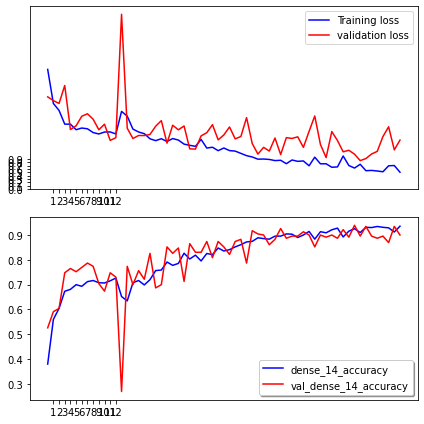

In [57]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,6))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 13, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.legend()

ax2.plot(history.history['dense_14_accuracy'], color='b', label="dense_14_accuracy")
ax2.plot(history.history['val_dense_14_accuracy'], color='r',label="val_dense_14_accuracy")
ax2.set_xticks(np.arange(1, 13, 1))
ax2.legend()

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()


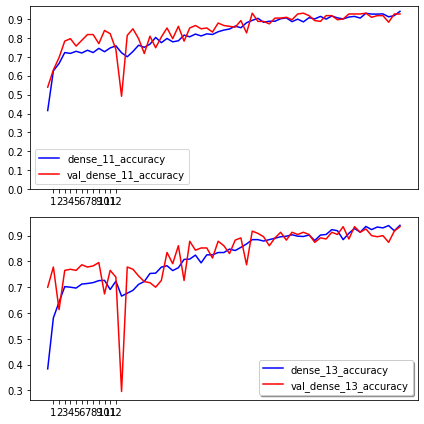

In [47]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,6))
ax1.plot(history.history['dense_11_accuracy'], color='b', label="dense_11_accuracy")
ax1.plot(history.history['val_dense_11_accuracy'], color='r', label="val_dense_11_accuracy")
ax1.set_xticks(np.arange(1, 13, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.legend()

ax2.plot(history.history['dense_13_accuracy'], color='b', label="dense_13_accuracy")
ax2.plot(history.history['val_dense_13_accuracy'], color='r',label="val_dense_13_accuracy")
ax2.set_xticks(np.arange(1, 13, 1))
ax2.legend()

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

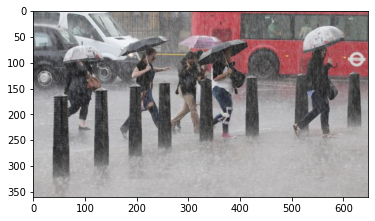

In [49]:


img_path="/Inception/MyDrive/Classification algorithm/CNN/dataset classification/test/rain/rain178.jpg"
test_image_orginal = image.load_img(img_path)
plt.imshow(test_image_orginal)


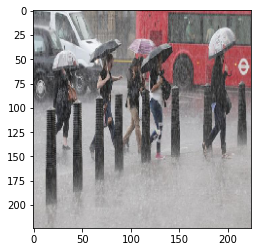

In [50]:


test_image = image.load_img(img_path, target_size=(224, 224))
plt.imshow(test_image)


In [51]:

test_image = image.img_to_array(test_image)
test_image.shape


(224, 224, 3)

In [52]:

test_image = np.expand_dims(test_image, axis=0)
test_image.shape


(1, 224, 224, 3)

In [53]:

test_set.class_indices.items()


dict_items([('cloudy', 0), ('rain', 1), ('shine', 2), ('sunrise', 3)])

In [58]:

prediction = model.predict(test_image)
prediction[2]

array([[0., 1., 0., 0.]], dtype=float32)

In [62]:
prediction[2][0][1]

1.0

**Prediction**

------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction is :       rain
------------------------------------------------------------------------------------------------------------------------------------------------------


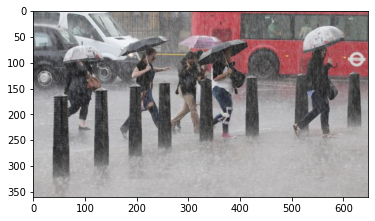

In [63]:


prediction = model.predict(test_image)
if(prediction[2][0][0]==1):
  print(f"-"*100)
  print("Prediction is :       cloudy")
  print(f"-"*150)
elif(prediction[2][0][1]==1):
  print(f"-"*150)
  print("Prediction is :       rain")
  print(f"-"*150)
elif(prediction[2][0][2]==1):
  print(f"-"*150)
  print("Prediction is :       shine")
  print(f"-"*150)
elif(prediction[2][0][3]==1):
  print(f"-"*150)
  print("Prediction is :       sunrise")
  print(f"-"*150)

plt.imshow(test_image_orginal)
plt.show()


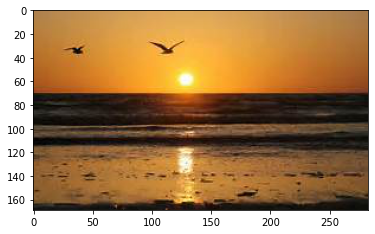

In [64]:
img_path="/Inception/MyDrive/Classification algorithm/CNN/dataset classification/test/sunrise/sunrise298.jpg"
test_image_orginal = image.load_img(img_path)
plt.imshow(test_image_orginal)

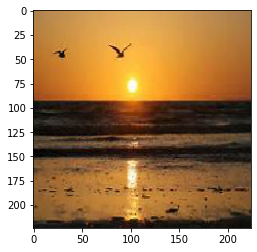

In [65]:
test_image = image.load_img(img_path, target_size=(224, 224))
plt.imshow(test_image)

In [66]:
test_image = image.img_to_array(test_image)
test_image.shape

(224, 224, 3)

In [67]:
test_image = np.expand_dims(test_image, axis=0)
test_image.shape


(1, 224, 224, 3)

------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction is :       sunrise
------------------------------------------------------------------------------------------------------------------------------------------------------


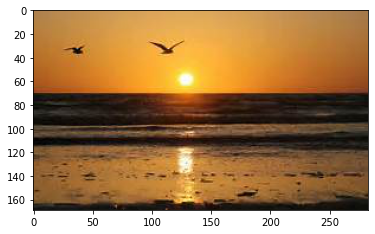

In [68]:
prediction = model.predict(test_image)
if(prediction[2][0][0]==1):
  print(f"-"*100)
  print("Prediction is :       cloudy")
  print(f"-"*150)
elif(prediction[2][0][1]==1):
  print(f"-"*150)
  print("Prediction is :       rain")
  print(f"-"*150)
elif(prediction[2][0][2]==1):
  print(f"-"*150)
  print("Prediction is :       shine")
  print(f"-"*150)
elif(prediction[2][0][3]==1):
  print(f"-"*150)
  print("Prediction is :       sunrise")
  print(f"-"*150)

plt.imshow(test_image_orginal)
plt.show()



In [ ]:
#https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/

In [ ]:
from google.colab import drive
drive.mount('/googlenet_or_inception')

Mounted at /googlenet_or_inception


In [ ]:

#!unzip '/googlenet_or_inception/MyDrive/CIFAR-10 - Object Recognition in Images.zip' -d '/googlenet_or_inception/MyDrive/googlenet_dataset'

In [ ]:
from tensorflow.keras.datasets import cifar10

In [ ]:
 (X_train, Y_train), (X_valid, Y_valid) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [ ]:
c=X_train[0].shape
c

(32, 32, 3)

In [ ]:
X_train[0]


array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [ ]:
import numpy as np
import cv2
#X_train = np.array([cv2.resize(img, (224,224)) for img in X_train[:,:,:,:]])

In [ ]:
Y_train.shape

(50000, 1)

In [ ]:
#install d21()
#!pip install d2l==0.15.1

     |████████████████████████████████| 61kB 5.8MB/s 


In [ ]:
#install -U mxnet-cu101(no need again installation)
#!pip install -U mxnet-cu101==1.7.0

     |███████████████████████████████▌| 834.1MB 1.3MB/s eta 0:00:10tcmalloc: large alloc 1147494400 bytes == 0x6577c000 @  0x7f9ea60d7615 0x591e47 0x4cc179 0x4cc2db 0x50a1cc 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50cc96 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x5095c8 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x5095c8 0x50a2fd
     |████████████████████████████████| 846.0MB 22kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
from d2l import tensorflow as d2l
import tensorflow as tf

class Inception(tf.keras.Model):
    # `c1`--`c4` are the number of output channels for each path
    def __init__(self, c1, c2, c3, c4):
        super().__init__()
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = tf.keras.layers.Conv2D(c1, 1, activation='relu')
        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
        # convolutional layer
        self.p2_1 = tf.keras.layers.Conv2D(c2[0], 1, activation='relu')
        self.p2_2 = tf.keras.layers.Conv2D(c2[1], 3, padding='same',
                                           activation='relu')
        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
        # convolutional layer
        self.p3_1 = tf.keras.layers.Conv2D(c3[0], 1, activation='relu')
        self.p3_2 = tf.keras.layers.Conv2D(c3[1], 5, padding='same',
                                           activation='relu')
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1
        # convolutional layer
        self.p4_1 = tf.keras.layers.MaxPool2D(3, 1, padding='same')
        self.p4_2 = tf.keras.layers.Conv2D(c4, 1, activation='relu')


    def call(self, x):
        p1 = self.p1_1(x)
        p2 = self.p2_2(self.p2_1(x))
        p3 = self.p3_2(self.p3_1(x))
        p4 = self.p4_2(self.p4_1(x))
        # Concatenate the outputs on the channel dimension
        return tf.keras.layers.Concatenate()([p1, p2, p3, p4])

In [ ]:
def b1():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, 7, strides=2, padding='same',
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

In [ ]:
def b2():
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 1, activation='relu'),
        tf.keras.layers.Conv2D(192, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

In [ ]:
def b3():
    return tf.keras.models.Sequential([
        Inception(64, (96, 128), (16, 32), 32),
        Inception(128, (128, 192), (32, 96), 64),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

In [ ]:
def b4():
    return tf.keras.Sequential([
        Inception(192, (96, 208), (16, 48), 64),
        Inception(160, (112, 224), (24, 64), 64),
        Inception(128, (128, 256), (24, 64), 64),
        Inception(112, (144, 288), (32, 64), 64),
        Inception(256, (160, 320), (32, 128), 128),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

In [ ]:
def b5():
    return tf.keras.Sequential([
        Inception(256, (160, 320), (32, 128), 128),
        Inception(384, (192, 384), (48, 128), 128),
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Flatten()
    ])
# Recall that this has to be a function that will be passed to
# `d2l.train_ch6()` so that model building/compiling need to be within
# `strategy.scope()` in order to utilize the CPU/GPU devices that we have
def net():
    return tf.keras.Sequential([b1(), b2(), b3(), b4(), b5(),
                                tf.keras.layers.Dense(10)])

In [ ]:
X = tf.random.uniform(shape=(1, 96, 96, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 (1, 24, 24, 64)
Sequential output shape:	 (1, 12, 12, 192)
Sequential output shape:	 (1, 6, 6, 480)
Sequential output shape:	 (1, 3, 3, 832)
Sequential output shape:	 (1, 1024)
Dense output shape:	 (1, 10)


In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)


loss 0.244, train acc 0.907, test acc 0.899
1434.7 examples/sec on /GPU:0


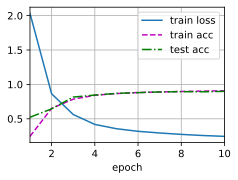

In [ ]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

inception_or_googlenet my implementation


In [ ]:
#https://www.kaggle.com/luckscylla/googlenet-implementation
#https://www.researchgate.net/figure/GoogleNet-architecture-31_fig2_332882012
#https://github.com/codebasics/py/blob/master/DeepLearningML/16_cnn_cifar10_small_image_classification/cnn_cifar10_dataset.ipynb
#!pip install d2l==0.15.1
#!pip install -U mxnet-cu101==1.7.0
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.layers import Conv2D,MaxPooling2D,AveragePooling2D,ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.datasets import cifar10
from keras.utils import np_utils


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#define different parameters
class_num=10
batch_size=16
epoch_steps=int(4323/batch_size)
image_shape=(32,32,3)
model_name="GoogLeNet_Flowers.h5"
#image_train_path='D:/machine learning tutorial/CNN model code/cnn model code/4.Inception_v1 or googlenet/dataset/Flowers Recognition/flowers'
#img=image.load_img(image_train_path+'/sunflower/24459750_eb49f6e4cb_m.jpg')
#plt.imshow(img)
(X_train, Y_train), (X_test, Y_test) =cifar10.load_data()

c=type(X_train)
print('c : ',c)
#converted the 2D array into 1D araray
y_train1=Y_train.reshape(-1,)
#classes of the dataset of cifar10
classes=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

def plot_sample(x,y,index):
    plt.figure(figsize=(15,2))
    plt.imshow(x[index])
    plt.xlabel(classes[y[index]])
    

img_rows,img_cols=32,32
X_train1 = X_train.reshape(X_train.shape[0], img_cols, img_rows, 3)
X_test1 = X_test.reshape(X_test.shape[0], img_cols, img_rows, 3)


X_train2 = X_train1.astype('float32')
X_test2 = X_test1.astype('float32')
X_train3 =X_train2/ 255
X_test3 =X_test2/ 255
Y_train_p = np_utils.to_categorical(Y_train, class_num)
Y_test_p = np_utils.to_categorical(Y_test, class_num)




170500096/170498071 [==============================] - 2s 0us/step
c :  <class 'numpy.ndarray'>


In [ ]:
#prepare data
# train_datagen=ImageDataGenerator(
#     rescale=1/255,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
#     )

# generator_main=train_datagen.flow_from_directory(
#     image_train_path,
#     target_size=(image_shape[0],image_shape[1]),
#     batch_size=batch_size,
#     class_mode='categorical'
#     )

# it shows integer value of the categorical variable
# how_many_class_in_dataset=generator_main.class_indices
# def my_generator(generator):
#     while(True):
#         data=next(generator)
#         x=data[0]
#         y=data[1],data[1],data[1]
#         #print('y : ',x)
#         yield x, y   
#         #return x
# train_generator=my_generator(generator_main)



In [ ]:

def Inception(x,filter):
    #inception is derived from the picture figure (but pic er flow(kar por konta) 
    #table theke nisi)
    #https://www.researchgate.net/figure/GoogleNet-architecture-31_fig2_332882012
    
    
    #1x1
    path1=Conv2D(filters=filter[0],kernel_size=(1,1),strides=1,padding='same',activation='relu')(x)
    
    #1x1 -> 3x3
    #table theke reduce and er porerta nia couple create korbo
    path2=Conv2D(filters=filter[1][0],kernel_size=(1,1),strides=1,padding='same',activation='relu')(x)
    path2=Conv2D(filters=filter[1][1],kernel_size=(3,3),strides=1,padding='same',activation='relu')(path2)
    
    #1x1 -> 5x5
    path3=Conv2D(filters=filter[2][0],kernel_size=(1,1),strides=1,padding='same',activation='relu')(x)
    path3=Conv2D(filters=filter[2][1],kernel_size=(5,5),strides=1,padding='same',activation='relu')(path3)
    
    #3x3 -> 1x1
    path4=MaxPooling2D(pool_size=(3,3),strides=1,padding='same')(x)
    
    path4=Conv2D(kernel_size=(1,1),filters=filter[3],strides=1,padding='same',activation='relu')(path4)
    #print(path1)
    return Concatenate(axis=-1)([path1,path2,path3,path4])

In [ ]:
def GoogLe_Net():
    input_layer=Input(image_shape)
    print('input_layer : ',input_layer)
    
    #stage #1:
    layer=Conv2D(filters=64,kernel_size=(7,7),strides=2,padding='same',activation='relu')(input_layer)
    #padding='same' means size of fearure map is same of 
    #output feature map
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(layer)
    layer=BatchNormalization()(layer)
    
    
    #stage #2:
    layer=Conv2D(filters=64,kernel_size=(1,1),strides=1,padding='same',activation='relu')(layer)
    layer=Conv2D(filters=192,kernel_size=(3,3),strides=1,padding='same',activation='relu')(layer)
    layer=BatchNormalization()(layer)
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(layer)
    
    
    #stage #3:
    layer=Inception(layer,[64,(96,128),(16,32),32])
    #table er reduce and reduce er porerta eksathe bracket a likbo
    layer=Inception(layer,[128,(128,192),(32,96),64])
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(layer)
    
    
    #stage #4:
    layer=Inception(layer,[192,(96,208),(16,48),64])#4a
    layer=Inception(layer,[160,(112,224),(24,64),64])#4b
    layer=Inception(layer,[128,(128,256),(24,64),64])#4c
    layer=Inception(layer,[112,(144,288),(32,64),64])#4d
    layer=Inception(layer,[256,(160,320),(32,128),128])#4e
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(layer)
    
    
    #stage #5:
    layer=Inception(layer,[256,(160,320),(32,128),128])#5a
    layer=Inception(layer,[384,(192,384),(48,128),128])#5b
    layer=AveragePooling2D(pool_size=(1,1),strides=1,padding='valid')(layer)
    
    
    #stage #6:
    layer=Flatten()(layer)
    layer=Dropout(.4)(layer)
    layer=Dense(units=256,activation='linear')(layer)
    main=Dense(units=class_num,activation='softmax',name='main')(layer)
    model=Model(inputs=input_layer,outputs=[main])
    return model
    

model=GoogLe_Net()
model.summary()

input_layer :  KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 8, 8, 64)     0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchN

In [ ]:
model.compile(loss='categorical_crossentropy',
             #loss_weights={'main':1},
             optimizer='adam',
             metrics=['accuracy']
             )

In [ ]:
train_history=model.fit(
    X_train3,
    Y_train_p,
    batch_size=128,
    epochs=13,
    #shuffle=True
    )

Epoch 1/13
391/391 [==============================] - 22s 31ms/step - loss: 1.8520 - accuracy: 0.2794
Epoch 2/13
391/391 [==============================] - 11s 28ms/step - loss: 1.3529 - accuracy: 0.5000
Epoch 3/13
391/391 [==============================] - 11s 28ms/step - loss: 1.1235 - accuracy: 0.6018
Epoch 4/13
391/391 [==============================] - 11s 28ms/step - loss: 0.9804 - accuracy: 0.6548
Epoch 5/13
391/391 [==============================] - 11s 28ms/step - loss: 0.8528 - accuracy: 0.7029
Epoch 6/13
391/391 [==============================] - 11s 28ms/step - loss: 0.7398 - accuracy: 0.7457
Epoch 7/13
391/391 [==============================] - 11s 28ms/step - loss: 0.6654 - accuracy: 0.7719
Epoch 8/13
391/391 [==============================] - 11s 28ms/step - loss: 0.5851 - accuracy: 0.8014
Epoch 9/13
391/391 [==============================] - 11s 28ms/step - loss: 0.5404 - accuracy: 0.8191
Epoch 10/13
391/391 [==============================] - 11s 29ms/step - loss: 0.488

In [ ]:
#evaluate the model
model.evaluate(X_test3,Y_test_p)

313/313 [==============================] - 3s 7ms/step - loss: 1.1157 - accuracy: 0.6967


[1.1156879663467407, 0.6966999769210815]

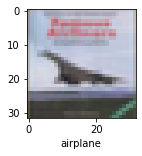

In [ ]:
y_1Darray=Y_test.reshape(-1,)
plot_sample(X_test3,y_1Darray,3)


In [ ]:
#prediction of the test dataset
y_pred=model.predict(X_test3)


In [ ]:
#preint all elements untill find 1(1 will be excluded)
y_pred[:1]

array([[2.5733418e-04, 1.7810507e-04, 1.5605311e-03, 7.6078367e-01,
        1.3658511e-03, 2.2976527e-01, 3.2307517e-03, 2.0194654e-03,
        3.6405993e-04, 4.7494867e-04]], dtype=float32)

In [ ]:
#find the index of maximum value
max_argmax=np.argmax([20,2,28,35,5,18])
max_argmax

3

In [ ]:
#find all max value and store in y_classes
y_pred_classes=[np.argmax(element) for element in y_pred]
y_pred_classes[:5]

[3, 8, 0, 0, 6]

In [ ]:
y_test1d=Y_test.reshape(-1)
y_test1d[:5]

array([3, 8, 8, 0, 6], dtype=uint8)

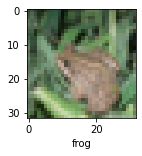

In [ ]:
#prediction calling the function
plot_sample(X_test3,y_1Darray,4)

In [ ]:
#print the class name form y_pred
classes[y_pred_classes[4]]

'frog'